In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics as stat
from datetime import datetime as dt
sns.set()

from scipy import stats
from scipy.stats import norm
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn import preprocessing
from sklearn.feature_selection import f_regression

In [2]:
df_raw = pd.read_csv('hdb_dataset_prep.csv')

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df_raw = df_raw.drop(['Unnamed: 0', 'resale_price'], axis=1)

As we see from the EDA, we observed that data from year 1990 to 2010 throw our statistics off. Estates and housing are constantly developing, and these past data no longer affects the price of the future. Therefore, the focus will be directed to dataset from year 2011 to 2020. Also to drop data from Lim Chu Kang estate as it has been entire demolished. 1 ROOM and 2 ROOM sale was removed due small data instances. Drop unneeded columns - month, flat_type_variable, storey range, block, street name, address, latitude,longitude, nearest mall, nearest mrt and cpi.

In [4]:
years20 = list(range(1990,2011))
flat_drop = ['1 ROOM',
             '2 ROOM',
             'MULTI GENERATION'
             ]
df_prep = df_raw[~df_raw.year.isin(years20)]
df_prep = df_prep.loc[df_prep['town'] != 'LIM CHU KANG']
df_prep = df_prep[~df_prep.flat_type.isin(flat_drop)]
df_prep = df_prep.drop(['month', 'storey_range', 'block', 'street_name','postal',
                        'address', 'latitude', 'longitude', 'nearest_mall', 'nearest_mrt','cpi'], axis=1)

df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192087 entries, 72 to 814413
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 192087 non-null  int64  
 1   town                 192087 non-null  object 
 2   flat_type            192087 non-null  object 
 3   flat_type_variable   192087 non-null  int64  
 4   avg_storey_range     192087 non-null  int64  
 5   floor_area_sqm       192087 non-null  float64
 6   flat_model           192087 non-null  object 
 7   lease_commence_date  192087 non-null  int64  
 8   remaining_lease      192087 non-null  int64  
 9   distance_to_mrt      192087 non-null  float64
 10  distance_to_mall     192087 non-null  float64
 11  distance_cbd         192087 non-null  float64
 12  adj_price            192087 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 20.5+ MB


## Correlation Matrix and Multicollinearity

Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model. 

1. If the largest VIF is greater than 10 then there is cause for concern (Bowerman & O’Connell, 1990; Myers, 1990)
2. If the average VIF is substantially greater than 1 then the regression may be biased (Bowerman & O’Connell, 1990).
3. Tolerance below 0.1 indicates a serious problem.
4. Tolerance below 0.2 indicates a potential problem (Menard, 1995).

C:\Users\edge\AppData\Local\Temp/ipykernel_7112/2664767408.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


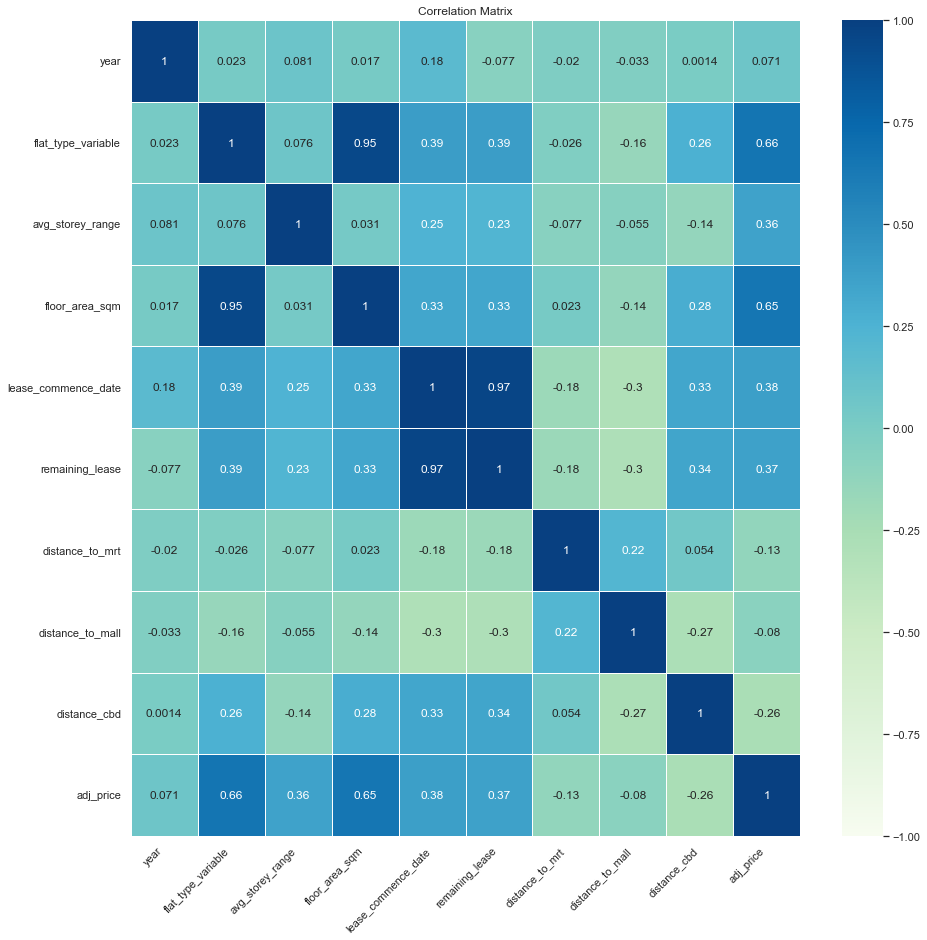

In [5]:
# Correlation heatmap
fig = plt.figure(figsize=(15,15))

ax = sns.heatmap(df_prep.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
    vmin=-1, vmax=1, center= 0, cmap= 'GnBu', linewidth=1, annot_kws={"size": 12})

plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix')
fig.show()

In [6]:
# Checking for multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

# derives VIF
def vif_index(X):
    vif = pd.DataFrame()
    vif["variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()
    return vif.round(4)

vif_index(df_prep.drop(['adj_price'],axis=1).select_dtypes(include=['int64','float64']))

,variable,VIF,tolerance,meanVIF
0,year,1.844060e+08,0.0000,4.265183e+07
1,flat_type_variable,1.026140e+01,0.0975,4.265183e+07
2,avg_storey_range,1.140800e+00,0.8766,4.265183e+07
3,floor_area_sqm,9.966500e+00,0.1003,4.265183e+07
4,lease_commence_date,1.991704e+08,0.0000,4.265183e+07
5,remaining_lease,2.900677e+05,0.0000,4.265183e+07
6,distance_to_mrt,1.111500e+00,0.8997,4.265183e+07
7,distance_to_mall,1.195400e+00,0.8365,4.265183e+07
8,distance_cbd,1.318900e+00,0.7582,4.265183e+07


In [7]:
vif_index(df_prep.drop(['adj_price', 'year','lease_commence_date','flat_type_variable'],axis=1).select_dtypes(include=['int64','float64']))

,variable,VIF,tolerance,meanVIF
0,avg_storey_range,3.6848,0.2714,12.1512
1,floor_area_sqm,19.6980,0.0508,12.1512
2,remaining_lease,30.5813,0.0327,12.1512
3,distance_to_mrt,3.6095,0.2770,12.1512
4,distance_to_mall,3.8112,0.2624,12.1512
5,distance_cbd,11.5222,0.0868,12.1512


Multicollinearities were spotted in the quantitative features. Even after removing several features, the highest VIF is 31 and floor_area_sqm and distance_cbd is above 10 as well. These features were not removed because from the EDA, these features show high relationship of determining the prices.

### Normality

In [8]:
df_norm = df_prep.drop(['year','lease_commence_date','flat_type_variable'], axis=1)

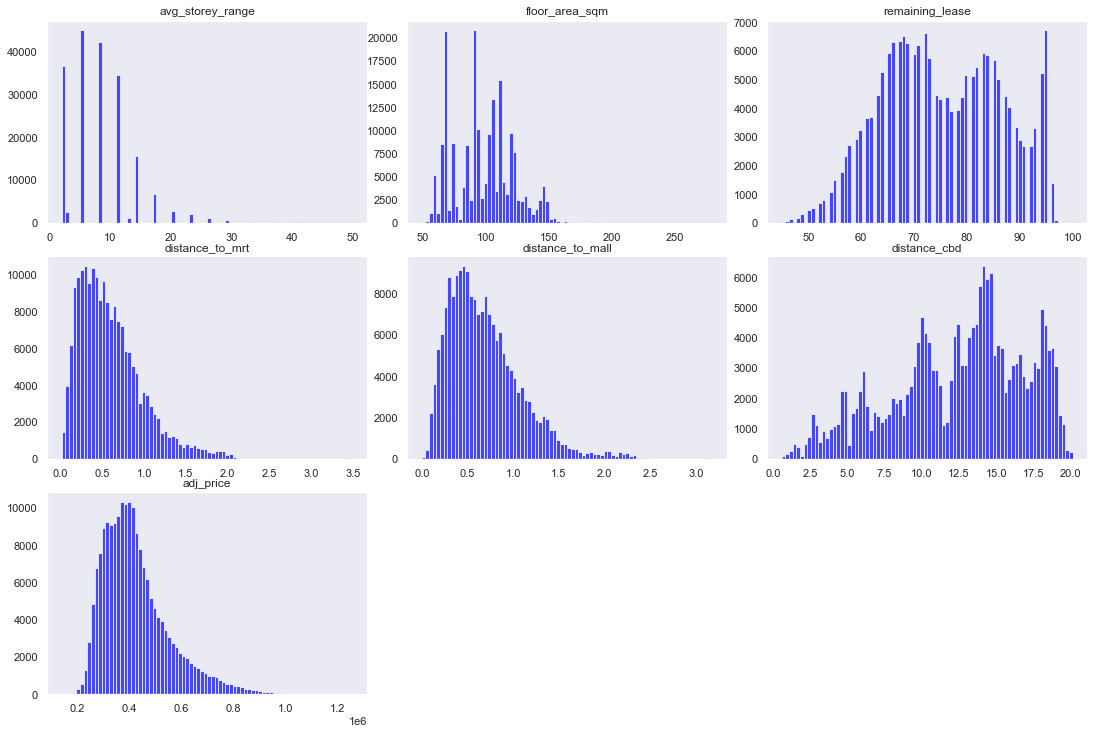

In [9]:
# Plot distribution for each continuous variable
df_norm.hist(bins=80, figsize=(15, 10), 
             grid=False, color='blue', alpha=0.7)
plt.tight_layout(pad=0, rect=[0, 0, 1, 1])
plt.show()

Not all the variables follow a normal distribution. For these outliers, its better to use a multivariable approach like <i>mahalanobis distance</i> to see if they are outliers instead of using a univariate approach. If needed, some of these variables can be transformed to reduce the skewness.

D:\Anaconda\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
D:\Anaconda\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


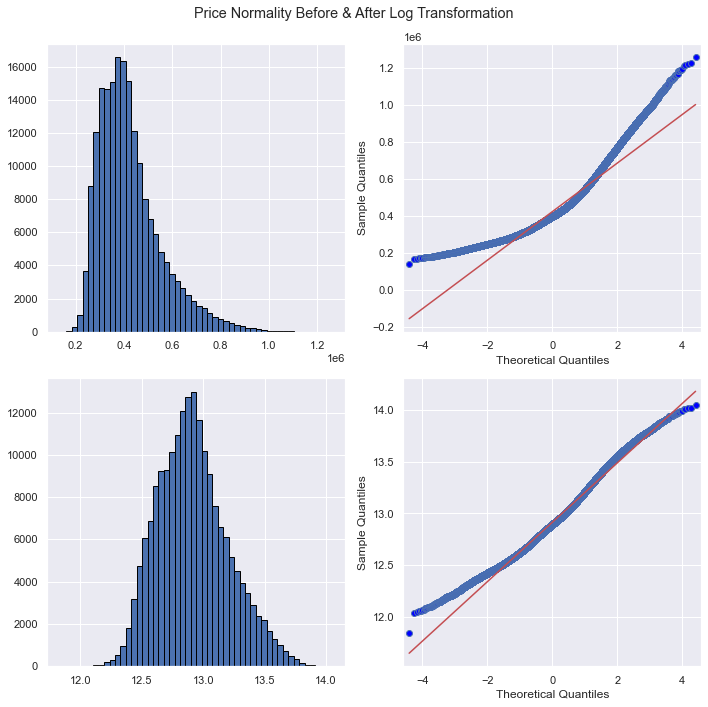

In [10]:
from statsmodels.api import qqplot

fig, ((ax1 ,ax2) , (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))

ax1.hist(df_norm['adj_price'], bins=50, edgecolor='black')
qqplot(df_norm['adj_price'], line='s', ax=ax2)
ax3.hist(np.log(df_norm['adj_price']), bins=50, edgecolor='black')
qqplot(np.log(df_norm['adj_price']), line='s', ax=ax4)
plt.suptitle('Price Normality Before & After Log Transformation')
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [11]:
df_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192087 entries, 72 to 814413
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   town              192087 non-null  object 
 1   flat_type         192087 non-null  object 
 2   avg_storey_range  192087 non-null  int64  
 3   floor_area_sqm    192087 non-null  float64
 4   flat_model        192087 non-null  object 
 5   remaining_lease   192087 non-null  int64  
 6   distance_to_mrt   192087 non-null  float64
 7   distance_to_mall  192087 non-null  float64
 8   distance_cbd      192087 non-null  float64
 9   adj_price         192087 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 16.1+ MB


#### Label & Encoding

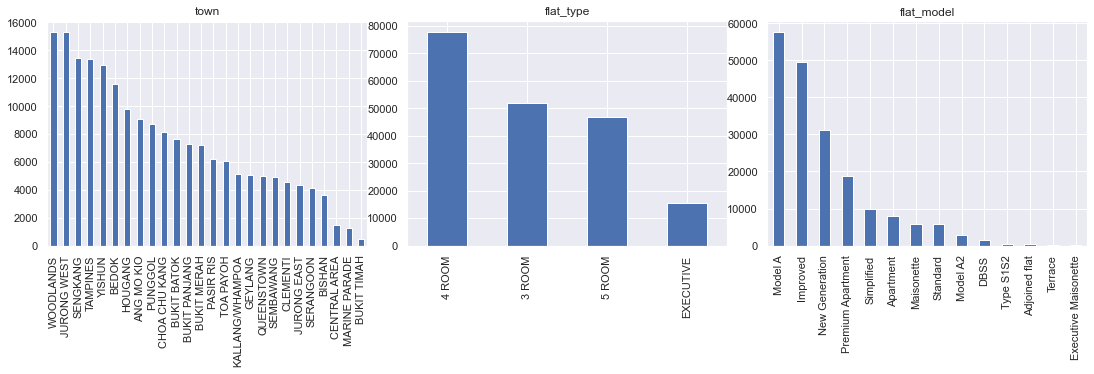

In [12]:
# Frequency plots for catergorical features

fig = plt.figure(figsize=(15,5))

for count, col in enumerate(df_norm.select_dtypes(include=['object']).columns):
    fig.add_subplot(1,3,count+1)
    df_norm[col].value_counts().plot.bar()
    plt.title(col)
    plt.tight_layout(pad=0, rect=[0, 0, 1, 1])

In [13]:
# Label encode flat type

replace_val = {'2 ROOM':0, '3 ROOM':1, '4 ROOM':2, '5 ROOM':3, 'EXECUTIVE':4}
df_prep = df_prep.replace({'flat_type': replace_val})
df_norm = df_norm.replace({'flat_type': replace_val})
df_norm.columns

Index(['town', 'flat_type', 'avg_storey_range', 'floor_area_sqm', 'flat_model',
       'remaining_lease', 'distance_to_mrt', 'distance_to_mall',
       'distance_cbd', 'adj_price'],
      dtype='object')

In [14]:
## dummy encoding

df_prep = pd.get_dummies(df_prep, columns=['town'], prefix=['town'], drop_first=True) # woodlands is baseline
df_prep = pd.get_dummies(df_prep, columns=['flat_model'], prefix=['model'])
df_prep = df_prep.drop('model_Standard',axis=1) # remove standard, setting it as the baseline

df_norm = pd.get_dummies(df_norm, columns=['town'], prefix=['town'], drop_first=True) # woodlands is baseline
df_norm = pd.get_dummies(df_norm, columns=['flat_model'], prefix=['model'])
df_norm = df_norm.drop('model_Standard',axis=1) # remove standard, setting it as the baseline

### Feature Scaling

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit to continuous columns and transform
scaled_col = ['avg_storey_range', 'floor_area_sqm', 'remaining_lease', 'distance_to_mrt', 
                  'distance_to_mall', 'distance_cbd']

scaler.fit(df_norm[scaled_col])
scaled_col = pd.DataFrame(scaler.transform(df_norm[scaled_col]), index=df_norm.index, columns=scaled_col)

# separate unscaled features
unscaled_col = df_norm.drop(scaled_col, axis=1)

# concatenate scaled and unscaled features
df_norm = pd.concat([scaled_col,unscaled_col], axis=1)

display(df_norm.head())

,avg_storey_range,floor_area_sqm,remaining_lease,distance_to_mrt,distance_to_mall,distance_cbd,flat_type,adj_price,town_BEDOK,town_BISHAN,...,model_Executive Maisonette,model_Improved,model_Maisonette,model_Model A,model_Model A2,model_New Generation,model_Premium Apartment,model_Simplified,model_Terrace,model_Type S1S2
72,-0.023534,1.972005,-0.204323,2.055997,1.619755,1.604664,4,458403.47,0,0,...,0,0,1,0,0,0,0,0,0,0
73,-0.023534,1.805018,-0.204323,2.055997,1.619755,1.604664,4,417076.46,0,0,...,0,0,0,0,0,0,0,0,0,0
74,-0.582082,1.972005,-0.204323,2.055997,1.619755,1.604664,4,438961.06,0,0,...,0,0,1,0,0,0,0,0,0,0
75,-0.023534,1.805018,-0.204323,2.055997,1.619755,1.604664,4,434280.43,0,0,...,0,0,0,0,0,0,0,0,0,0
76,-0.582082,1.805018,-0.292469,2.055997,1.619755,1.604664,4,443982.62,0,0,...,0,0,0,0,0,0,0,0,0,0


### Outlier Detection

Cook's Distance is preferred as Mahalanobis Distance requires too much memory. This is use to identify points that negatively affect the regression model. The threshold for Cook's Distance used here is 4/n.

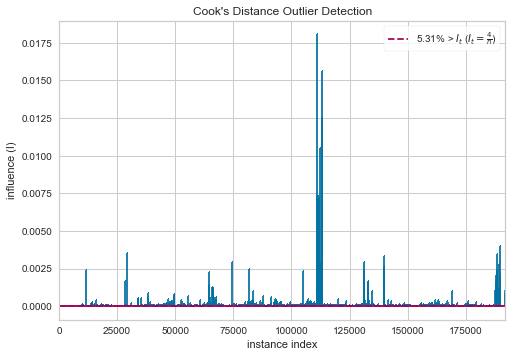

In [16]:
from yellowbrick.regressor import CooksDistance

y_D = df_norm[['adj_price']]
x_d = df_norm.drop(['adj_price'], axis=1)

YD = np.log(y_D)['adj_price']
XD = x_d.values

visualizer = CooksDistance()
visualizer.fit(XD, YD)
visualizer.show()
plt.close()

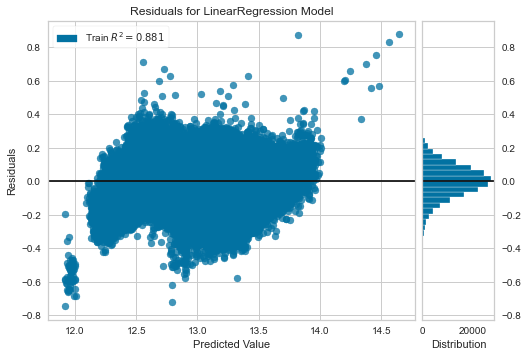

In [17]:
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression

# to visualize residuals before removing outliers

reg_ = LinearRegression()
visualizer_residuals = ResidualsPlot(reg_)
visualizer_residuals.fit(XD, YD)
visualizer_residuals.show()
plt.close()

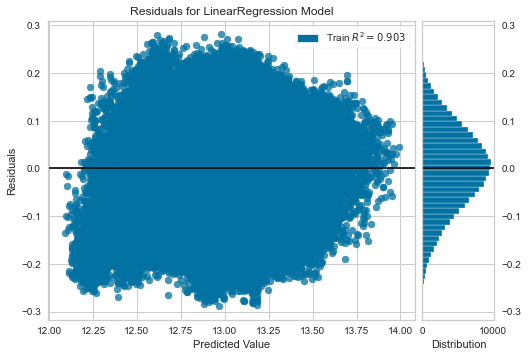

In [18]:
# to remove outliers
i_influential = (visualizer.distance_ <= visualizer.influence_threshold_)

x_inf, y_inf = XD[i_influential], YD[i_influential]
x_d, y_D = x_d[i_influential], y_D[i_influential]

# to visualize residuals after removing outliers

reg_ = LinearRegression()
visualizer_residuals = ResidualsPlot(reg_)
visualizer_residuals.fit(x_inf, y_inf)
visualizer_residuals.show()
plt.close()

After removing the outliers (5.31%) , the homoscedaticity becomes better, the distances from the points to the straight is shorter. The residuals are normally distributed around 0, satisfying the linearity and normality assumptions of the linear model.

#### Next: Model building